In [ ]:
#Find the threshold for the percentile
import filtering  
df = filtering.moses_to_df("data/en-si/GNOME.en-si.en", "data/en-si/GNOME.en-si.si", "english", "sinhala")
e1 = filtering.to_multilingual_embedding("english", df["english"], "labse")
e2 = filtering.to_multilingual_embedding("sinhala", df["sinhala"], "labse")
ss = filtering.find_similarity_score(e1, e2)

ModuleNotFoundError: No module named 'pyplot'

(array([ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  1.,  3.,  1.,  1.,
         0.,  1.,  1.,  1.,  0.,  1.,  0.,  2.,  2.,  1.,  0.,  1.,  1.,
         1.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,  0.,  0.,  5.,  1.,
         1.,  0.,  1.,  3.,  1.,  1.,  1.,  1.,  3.,  4.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  2.,  1.,  4.,  1.,  3.,  0.,  0.,  0.,
         0.,  0.,  1.,  3.,  4.,  1.,  1.,  0.,  3.,  2.,  1.,  1.,  1.,
         3.,  0.,  1.,  3.,  3.,  0.,  1.,  1.,  1.,  2.,  4.,  3.,  0.,
         1.,  3.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,  5.,  0.,
         3.,  4.,  1.,  3.,  1.,  0.,  4.,  1.,  2.,  0.,  2.,  0.,  1.,
         0.,  4.,  2.,  2.,  2.,  2.,  3.,  2.,  0.,  4.,  3.,  3.,  2.,
         2.,  1.,  0.,  0.,  1.,  4.,  4.,  2.,  0.,  2.,  2.,  2.,  2.,
         1.,  2.,  4.,  2.,  1.,  4.,  1.,  3.,  2.,  1.,  2.,  4.,  6.,
         2.,  4.,  1.,  2.,  2.,  0.,  5.,  1.,  6.

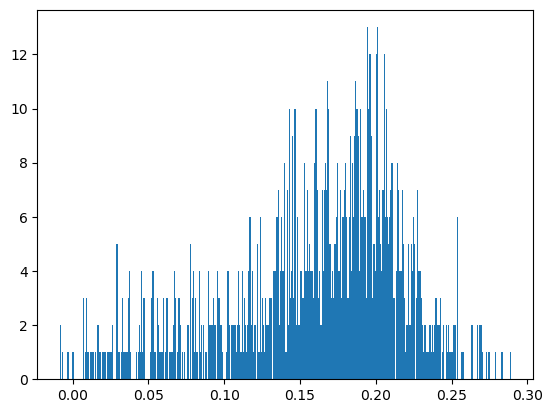

In [10]:
import matplotlib.pyplot as plt
plt.hist(ss, bins=400)